# SB 3bet vs BU call GTO+ Flop Betting Analysis

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import itertools
import poker
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns',30)

### Visualizing Ranges

In [138]:
sb_hand_matrix = pd.DataFrame(np.zeros((13,13)))
sb_hand_matrix.columns = list(card_value_map.keys())[::-1]
sb_hand_matrix.index = list(card_value_map.keys())[::-1]
cards = ['A','K','Q','J','T','9','8','7','6','5','4','3','2']

def hand_matrix_template(cards_list,v):
    
    matrix = []
    
    for i in range(len(cards_list)):
        matrix.append([cards[i]+cards[j]+'s' if v[cards[i]] > v[cards[j]] 
                       else cards[i]+cards[j] if cards[i] == cards[j] 
                       else cards[j]+cards[i]+'o' 
                       for j in range(len(cards))])
    
    matrix = pd.DataFrame(np.array(matrix))
    matrix.columns = cards
    matrix.index = cards
    
    return matrix  


sb_range_frq = np.array([[1,1,1,1,1,1,1,.819,.122,1,1,0,0],
                         [1,1,1,1,1,1,0,0,0,0,0,0,0],
                         [1,1,1,1,1,.589,0,0,0,0,0,0,0],
                         [1,1,.206,1,1,.477,0,0,0,0,0,0,0],
                         [1,.492,0,0,1,.543,0,0,0,0,0,0,0],
                         [0,0,0,0,0,1,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,1,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,1,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,.715,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,.245,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0]])
sb_range_frq_df = pd.DataFrame(sb_range_frq)
sb_range_frq_df.index = cards
sb_range_frq_df.columns = cards

hand_frq_map = {}

for i in range(hand_matrix_template(cards,card_value_map).shape[0]):
    
    temp_dict = dict(zip(hand_matrix_template(cards,card_value_map).to_numpy()[i],sb_range_frq[i]))
    
    #print(temp_dict)
    
    hand_frq_map.update(temp_dict)
    
bu_range_frq = np.array([[0,0,.779,1,1,.681,.162,0,0,.251,.262,.0038,0],
                         [0,0,1,1,1,.367,0,0,0,0,0,0,0],
                         [.85,.354,0,.719,.408,0,0,0,0,0,0,0,0],
                         [.411,0,0,0,1,0,0,0,0,0,0,0,0],
                         [0,0,0,0,.32,.543,0,0,0,0,0,0,0],
                         [0,0,0,0,0,1,.551,0,0,0,0,0,0],
                         [0,0,0,0,0,0,1,.227,0,0,0,0,0],
                         [0,0,0,0,0,0,0,1,.241,0,0,0,0],
                         [0,0,0,0,0,0,0,0,.828,.232,0,0,0],
                         [0,0,0,0,0,0,0,0,0,.601,.2,0,0],
                         [0,0,0,0,0,0,0,0,0,0,.493,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,.404,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,.403]])
bu_range_frq_df = pd.DataFrame(bu_range_frq)
bu_range_frq_df.index = cards
bu_range_frq_df.columns = cards


Heat map values represent the frequency at which each player shows up with a given hand in this scenario heading to the flop.

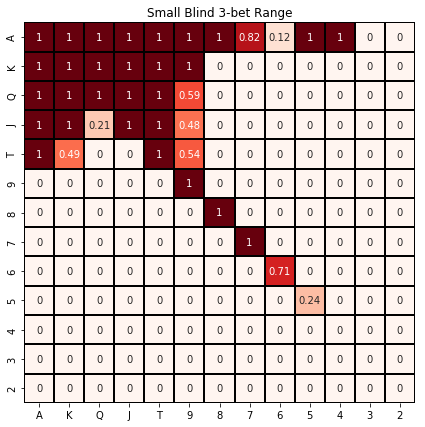

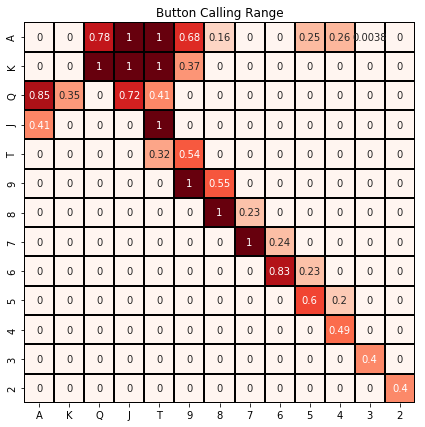

In [140]:
fig,ax = plt.subplots()
fig.set_size_inches(7,7)
sns.heatmap(sb_range_frq_df, cmap = 'Reds',linewidths = 1,linecolor = 'black',annot = True,cbar = False)
plt.title('Small Blind 3-bet Range')
plt.show()

fig,ax = plt.subplots()
fig.set_size_inches(7,7)
sns.heatmap(bu_range_frq_df, cmap = 'Reds',linewidths = 1,linecolor = 'black',annot = True,cbar = False)
plt.title('Button Calling Range')
plt.show()

### Importing GTO+ Aggregate Report and Feature Engineering

In [3]:
df = pd.read_csv(r'C:\Users\robla\Desktop\Python GTO Analyses\GTO_files\SBvsBU_3bet_pot_100bb.csv')
df.loc[162] = list(df.columns)
df.columns = ['flop','equity','ev','bet_100%_frequency','bet_75%_frequency','bet_50%_frequency','bet_25%_frequency','check_frequency']
df = df.sort_values(by = 'equity', ascending = False).reset_index(drop = True)
summary  = df.loc[df['flop'] == '163 flops']
df = df.loc[df['flop'] != '163 flops']

df.loc[:,'flop_suits'] =  df['flop'].apply(lambda x: [i for i in x[1::2]])
df.loc[:,'flop_values'] =  df['flop'].apply(lambda x: [i for i in x[0::2]])

card_value_map = dict(zip(['2','3','4','5','6','7','8','9','T','J','Q','K','A'],np.arange(1,14)))
reverse_card_value_map = dict(zip(np.arange(1,14),['2','3','4','5','6','7','8','9','T','J','Q','K','A']))


df.loc[:,'flop_num_values'] = df['flop_values'].apply(lambda x: [card_value_map[i] for i in x])
df.loc[:,'pairwise_gaps'] = df['flop_num_values'].apply(lambda x: [abs(x[0]-x[1]),abs(x[0]-x[2]),abs(x[1]-x[2])])
df.loc[:,'mean_pairwise_gap'] = df['pairwise_gaps'].apply(lambda x: np.mean(x))
df.loc[:,'std_pairwise_gap'] = df['pairwise_gaps'].apply(lambda x: np.std(x))
df.loc[:,'flop_std'] = df['flop_num_values'].apply(lambda x: np.std(x))
df.loc[:,'flop_mean'] = df['flop_num_values'].apply(lambda x: np.mean(x))
df.loc[:,'suitedness'] = df['flop_suits'].apply(lambda x: len(set(x)))
df.loc[:,'pairedness'] = df['flop_values'].apply(lambda x: len(set(x)))

df.loc[:,'equity'] = df['equity'].apply(lambda x: float(x))
df.loc[:,'ev'] = df['ev'].apply(lambda x: float(x))
df.loc[:,'bet_100%_frequency'] = df['bet_100%_frequency'].apply(lambda x: float(x))
df.loc[:,'bet_75%_frequency'] = df['bet_75%_frequency'].apply(lambda x: float(x))
df.loc[:,'bet_50%_frequency'] = df['bet_50%_frequency'].apply(lambda x: float(x))
df.loc[:,'bet_25%_frequency'] = df['bet_25%_frequency'].apply(lambda x: float(x))
df.loc[:,'check_frequency'] = df['check_frequency'].apply(lambda x: float(x))

df.loc[:,'big_bet_frequency'] = df['bet_75%_frequency'] + df['bet_100%_frequency']
df.loc[:,'small_bet_frequency'] = df['bet_25%_frequency'] + df['bet_50%_frequency']
df.loc[:,'bet_frequency'] = 100 - df['check_frequency']


df.loc[:,'high_card_num'] = df['flop_num_values'].apply(lambda x: max(x))
df.loc[:,'high_card'] = df['high_card_num'].apply(lambda x: reverse_card_value_map[x])

In [141]:
df.head(20)

,flop,equity,ev,bet_100%_frequency,bet_75%_frequency,bet_50%_frequency,bet_25%_frequency,check_frequency,flop_suits,flop_values,flop_num_values,pairwise_gaps,mean_pairwise_gap,std_pairwise_gap,flop_std,flop_mean,suitedness,pairedness,big_bet_frequency,small_bet_frequency,bet_frequency,high_card_num,high_card
0,AsKdJh,66.368,15.772,0.663,4.469,10.106,84.757,0.006,"[s, d, h]","[A, K, J]","[13, 12, 10]","[1, 3, 2]",2.000000,0.816497,1.247219,11.666667,3,3,5.132,94.863,99.994,13,A
1,AcKhJh,65.367,15.323,1.175,2.747,17.657,78.415,0.005,"[c, h, h]","[A, K, J]","[13, 12, 10]","[1, 3, 2]",2.000000,0.816497,1.247219,11.666667,2,3,3.922,96.072,99.995,13,A
2,AsAcKs,63.828,14.810,0.000,0.000,5.784,71.939,22.277,"[s, c, s]","[A, A, K]","[13, 13, 12]","[0, 1, 1]",0.666667,0.471405,0.471405,12.666667,2,2,0.000,77.723,77.723,13,A
3,KdQsJd,63.579,15.050,3.466,0.016,14.261,82.254,0.004,"[d, s, d]","[K, Q, J]","[12, 11, 10]","[1, 2, 1]",1.333333,0.471405,0.816497,11.000000,2,3,3.482,96.515,99.996,12,K
4,AcKs2d,61.600,13.717,0.098,0.002,1.567,73.996,24.338,"[c, s, d]","[A, K, 2]","[13, 12, 1]","[1, 12, 11]",8.000000,4.966555,5.436502,8.666667,3,3,0.100,75.563,75.662,13,A
5,KcKhJd,61.316,16.618,0.000,10.305,39.344,50.349,0.003,"[c, h, d]","[K, K, J]","[12, 12, 10]","[0, 2, 2]",1.333333,0.942809,0.942809,11.333333,3,2,10.305,89.693,99.997,12,K
6,KdJcTs,61.157,12.639,0.000,0.000,0.000,31.235,68.765,"[d, c, s]","[K, J, T]","[12, 10, 9]","[2, 3, 1]",2.000000,0.816497,1.247219,10.333333,3,3,0.000,31.235,31.235,12,K
7,AsJh2d,60.773,13.623,0.004,0.004,16.861,62.155,20.976,"[s, h, d]","[A, J, 2]","[13, 10, 1]","[3, 12, 9]",8.000000,3.741657,5.099020,8.000000,3,3,0.008,79.016,79.024,13,A
8,AdKc4d,60.497,13.199,2.399,0.014,12.446,49.188,35.953,"[d, c, d]","[A, K, 4]","[13, 12, 3]","[1, 10, 9]",6.666667,4.027682,4.496913,9.333333,2,3,2.413,61.634,64.047,13,A
9,QcJcTc,60.467,15.076,25.544,38.690,27.390,8.200,0.176,"[c, c, c]","[Q, J, T]","[11, 10, 9]","[1, 2, 1]",1.333333,0.471405,0.816497,10.000000,1,3,64.234,35.590,99.824,11,Q


In [6]:
df.loc[:,'high_card'].value_counts()

A    35
K    29
Q    24
J    21
T    17
9    12
8     9
7     8
4     3
6     3
3     2
Name: high_card, dtype: int64

- No 5 high flops?

In [7]:
action_avgs = pd.DataFrame(df[['flop','bet_100%_frequency',
                               'bet_75%_frequency','bet_50%_frequency',
                               'bet_25%_frequency','check_frequency']].mean())
action_avgs.columns = ['avg_frequency']
action_avgs

,avg_frequency
bet_100%_frequency,4.155638
bet_75%_frequency,13.102859
bet_50%_frequency,21.018675
bet_25%_frequency,26.516951
check_frequency,35.205939


As the preflop agressor 3betting a BU open raise

- Broadly speaking the SB does a lot of checking and small betting, large bets only acocunt for roughly 17% of actions taken.
- Checking and small betting accounts for 61% of SB actions
- Betting (regardless of size) accounts for 65% of SB actions 

### Visualizing Bet Size Frequencies and Range Equity vs. Flop High Card

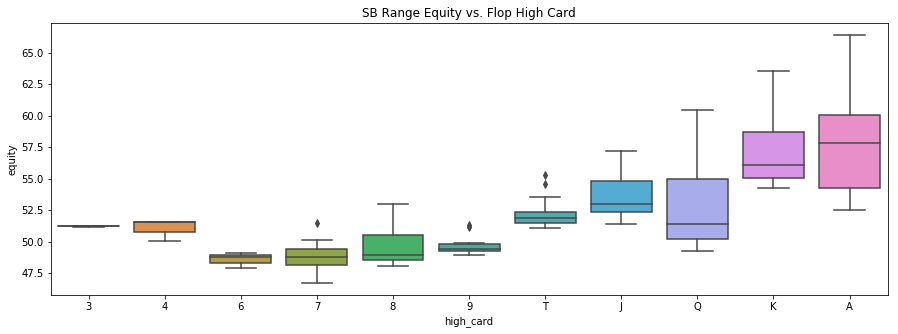

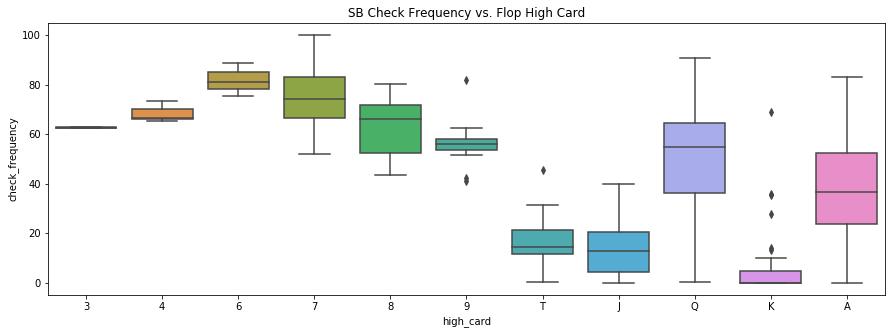

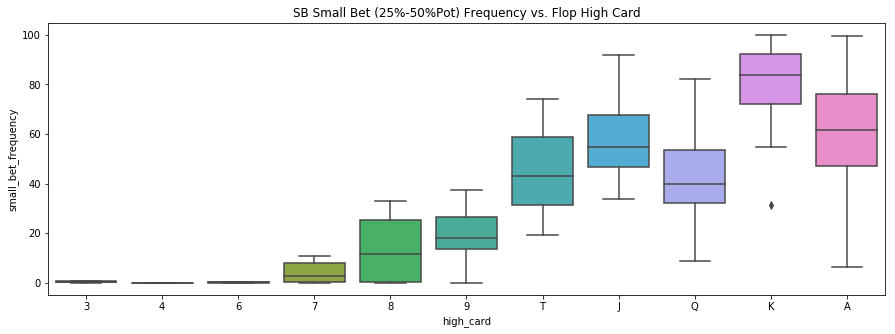

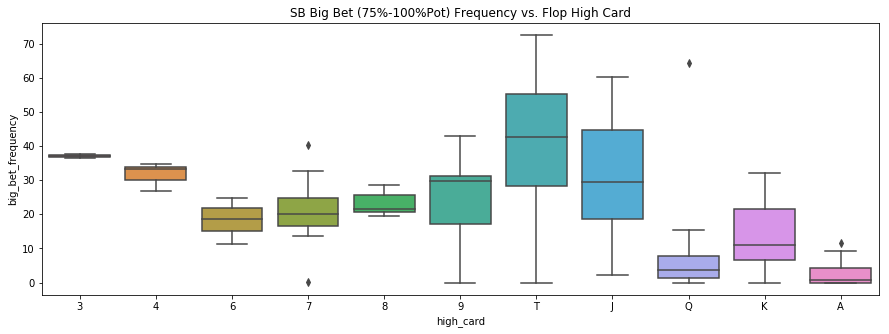

In [143]:
fig,ax = plt.subplots()
fig.set_size_inches(15,5)
sns.boxplot(data = df.sort_values(by = 'high_card_num'),
             x = 'high_card', 
             y = 'equity')
plt.title('SB Range Equity vs. Flop High Card')
plt.show('pdf')

fig,ax = plt.subplots()
fig.set_size_inches(15,5)
sns.boxplot(data = df.sort_values(by = 'high_card_num'),
             x = 'high_card', 
             y = 'check_frequency')
plt.title('SB Check Frequency vs. Flop High Card')
plt.show('pdf')


fig,ax = plt.subplots()
fig.set_size_inches(15,5)
sns.boxplot(data = df.sort_values(by = 'high_card_num'),
             x = 'high_card', 
             y = 'small_bet_frequency')
plt.title('SB Small Bet (25%-50%Pot) Frequency vs. Flop High Card')
plt.show('pdf')


fig,ax = plt.subplots()
fig.set_size_inches(15,5)
sns.boxplot(data = df.sort_values(by = 'high_card_num'),
             x = 'high_card', 
             y = 'big_bet_frequency')
plt.title('SB Big Bet (75%-100%Pot) Frequency vs. Flop High Card')
plt.show('pdf')

Initial findings from the GTO+ solver's persepective as the pre-flop aggresor in the SB:

- SB rarely checks T,J, and K high flops. Consequently, the solver bets often using a small (25% or 50% pot) continuation bet size.
- A and Q high boards have the biggest variance in terms of how often the solver opts to check. However, they are still bet quite often with preference for a small bet size (25% or 50% pot).
- 9 high and below boards are checked the most frequently, and when bet, the solver tends to opts for a larger sizing (50% or 75% pot).
- Of these low and mid flops, 7 and 8 high boards have the biggest variance in terms of how often the solver opts to check. Moreover, specifically on the 8 high boards the solver mixes it up between big and small bets.